In [1]:
# correct_dir = False
# if not correct_dir:
#     import os
#     os.chdir('..')
#     correct_dir = True

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch

In [2]:
from rllib_emecom.utils.experiment_utils import initialise_ray
initialise_ray()

pygame 2.3.0 (SDL 2.24.2, Python 3.8.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/ray/anaconda3/lib/python3.8/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
2023-10-14 11:08:09,646	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.8.0 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-10-14 11:08:11,742	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.8.0 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/ray/anaconda3/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/home/ray/anaconda3/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:58: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version

In [3]:
from IPython.display import clear_output
from ray.rllib.algorithms.algorithm import Algorithm

In [4]:
runs_dir = 'ray_results/goal_comms_gridworld/goal_comms_gridworld'
run = 'PPO_goal_comms_gridworld_970ba_00000_0_2023-10-13_22-33-54'
ckpt = 'checkpoint_000099'
algo = Algorithm.from_checkpoint(f'{runs_dir}/{run}/{ckpt}')
clear_output()
print('Loaded checkpoint.')

Loaded checkpoint.


In [5]:
eval_results = algo.evaluate()

mean_reward = eval_results['evaluation']['sampler_results']['episode_reward_mean']
mean_episode_length = eval_results['evaluation']['sampler_results']['episode_len_mean']

print(f'Mean reward: {mean_reward}, Mean episode length: {mean_episode_length}')

(RolloutWorker pid=50932) WARNING:imageio_ffmpeg:IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1812, 608) to (1824, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
(RolloutWorker pid=50932) [rawvideo @ 0x6ad67c0] Stream #0: not enough frames to estimate rate; consider increasing probesize


(RolloutWorker pid=50932) Saved evaluation video to /home/ray/ray_results/PPO_goal_comms_gridworld_2023-10-14_11-08-2170cuhkhl//videos//video_2023-10-14_11-08-44.mp4
Mean reward: -4.72, Mean episode length: 4.84


In [6]:
from rllib_emecom.utils.video_utils import embed_mp4
media = eval_results['evaluation']['sampler_results']['episode_media']
for k in media:
    if k.startswith('env'):
        video, *_ = media[k]
        break
embed_mp4(video._path)

In [47]:
from typing import Optional, Dict, Union

from ray.rllib.core.models.base import SampleBatch
from ray.rllib.algorithms.callbacks import DefaultCallbacks, make_multi_callbacks
from ray.rllib.evaluation.episode import Episode
from ray.rllib.evaluation.episode_v2 import EpisodeV2
from ray.rllib.utils.typing import PolicyID
from ray.rllib import Policy, BaseEnv

from rllib_emecom.utils.video_callback import get_sub_env
from rllib_emecom.macrl.ppo.macrl_ppo_module import PPOTorchMACRLModule
from rllib_emecom.env.goal_comms_gridworld import parallel_env as GoalCommsGridworldEnv


class CollectCommsDataCallback(DefaultCallbacks):

    def __init__(self):
        super().__init__()
        self.data = []

    def get_env_state(self, goal_comms_env: GoalCommsGridworldEnv) -> dict:
        agent_ids = goal_comms_env.agents

        def get_known_goal_agent(agent):
            # agent knows the goal of agent_goal_map[agent]
            other_agent = goal_comms_env.agent_goal_map[agent]
            return agent_ids[other_agent.index]

        return {
            # key knows the goal of the value
            # so key is the sender and value is the receiver
            'goal_knowledge_map' : {
                agent: get_known_goal_agent(agent)
                for agent in agent_ids
            },
            'agent_positions': {
                agent: goal_comms_env.agents_map[agent].pose
                for agent in agent_ids
            },
            'goal_positions': {
                agent: goal_comms_env.agents_map[agent].goal
                for agent in agent_ids
            },
        }

    def on_episode_step(
        self,
        *,
        worker,
        base_env: BaseEnv,
        policies: Optional[Dict[PolicyID, Policy]] = None,
        episode: Union[Episode, EpisodeV2],
        env_index: Optional[int] = None,
        **kwargs,
    ) -> None:
        macrl_module = policies['default_policy'].model
        assert isinstance(macrl_module, PPOTorchMACRLModule)
        env = get_sub_env(base_env, env_index)
        goal_comms_env = env.env.unwrapped.par_env
        assert isinstance(goal_comms_env, GoalCommsGridworldEnv)

        last_action_logits = {   
            agent_id: action_batch[SampleBatch.ACTION_DIST_INPUTS][env_index].detach().cpu().numpy()
            for agent_id, action_batch in macrl_module.last_actor_outputs.items()
        }

        self.data.append({
            'comms': macrl_module.get_last_msgs(env_index),
            'total_env_steps': episode.total_env_steps,
            'total_reward': episode.total_reward,
            'episode_id': episode.episode_id,
            'env_index': env_index,
            'last_obs': macrl_module.last_inputs[SampleBatch.OBS][env_index],
            'last_action_logits': last_action_logits,
            'env_state': self.get_env_state(goal_comms_env),
        })

In [64]:
from rllib_emecom.utils.video_callback import VideoEvaluationsCallback
from ray.rllib.evaluation.worker_set import WorkerSet

eval_config = algo.evaluation_config.copy(copy_frozen=False)
eval_config.callbacks_class = CollectCommsDataCallback

eval_worker_set = WorkerSet(
    env_creator=algo.env_creator,
    validate_env=None,
    default_policy_class=algo.get_default_policy_class(algo.config),
    config=eval_config,
    num_workers=0,
    logdir=algo.logdir,
)

worker = eval_worker_set.local_worker()
algo.evaluation_workers = eval_worker_set
collect_comms_data_cb = worker.callbacks
collect_comms_data_cb.data.clear()

2023-10-14 12:34:20,020	WARNING algorithm_config.py:2574 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.


Building MACRL module...
Comms spec: {'message_dim': 8, 'comm_channels': {'agent_0': ['agent_1', 'agent_2'], 'agent_1': ['agent_0', 'agent_2'], 'agent_2': ['agent_0', 'agent_1']}, 'channel_fn': 'gumbel_softmax', 'channel_fn_config': {'temperature': 10.0, 'temperature_annealing': False, 'n_anneal_iterations': 500, 'final_temperature': 0.5, 'channel_noise': 0.25, 'channel_activation': 'tanh'}, 'n_agents': 3}
Communication channel function: <rllib_emecom.macrl.comms.gumbel_softmax.GumbelSoftmaxCommunicationChannel object at 0x7f5dd858a520>


In [102]:
n_evals = 30

mean_reward = 0
mean_episode_length = 0

for _ in range(n_evals):
    eval_results = algo.evaluate()

    mean_reward += eval_results['evaluation']['sampler_results']['episode_reward_mean']
    mean_episode_length += eval_results['evaluation']['sampler_results']['episode_len_mean']

mean_reward /= n_evals
mean_episode_length /= n_evals

print(f'Mean reward: {mean_reward}, Mean episode length: {mean_episode_length}')

Mean reward: -4.965333333333334, Mean episode length: 4.814666666666666


In [103]:
len(collect_comms_data_cb.data)

4832

In [104]:
collect_comms_data_cb.data[0]

{'comms': {'agent_0': {'agent_1': array([7.9238847e-02, 8.6372427e-05, 1.2924148e-06, 9.3052367e-04,
          9.1565317e-01, 5.6834001e-04, 4.0389528e-04, 3.1176014e-03],
         dtype=float32),
   'agent_2': array([8.7740125e-05, 6.9995971e-05, 2.3303584e-03, 5.0345963e-05,
          1.2889783e-02, 3.1926349e-04, 8.5743683e-05, 9.8416674e-01],
         dtype=float32)},
  'agent_1': {'agent_0': array([1.3980037e-03, 2.5274265e-05, 4.0923795e-05, 3.6805555e-05,
          1.1517285e-04, 6.0492731e-04, 9.7390985e-01, 2.3869069e-02],
         dtype=float32),
   'agent_2': array([2.5751775e-03, 1.1053578e-03, 6.7360255e-05, 3.4202636e-05,
          2.0030758e-03, 3.4818423e-01, 6.1155194e-01, 3.4478620e-02],
         dtype=float32)},
  'agent_2': {'agent_0': array([3.5065976e-03, 6.6949480e-04, 8.2590681e-04, 2.1229111e-01,
          5.6267544e-03, 7.7490705e-01, 1.2383032e-04, 2.0492910e-03],
         dtype=float32),
   'agent_1': array([8.5158892e-05, 9.6993309e-01, 3.0202969e-04, 1.036

In [128]:
df = pd.DataFrame([
    {
        'receiver': recv_agent,
        'sender': send_agent,
        'goal_x': item['env_state']['goal_positions'][recv_agent][0],
        'goal_y': item['env_state']['goal_positions'][recv_agent][1],
        'pos_x': item['env_state']['agent_positions'][recv_agent][0],
        'pos_y': item['env_state']['agent_positions'][recv_agent][1],
        'receiver_action': np.argmax(item['last_action_logits'][recv_agent]),
        'msg': np.argmax(item['comms'][recv_agent][send_agent]),
        **{
            f'msg_{i}': v
            for i, v in enumerate(item['comms'][recv_agent][send_agent])
        },
    }
    for item in collect_comms_data_cb.data
    for recv_agent in item['comms']
    for send_agent in item['comms'][recv_agent]
    if item['env_state']['goal_knowledge_map'][send_agent] == recv_agent
])
msg_cols = [col for col in df.columns if col.startswith('msg_')]
world_w, world_h = eval_config.env_config['world_shape']
df['goal_idx'] = df['goal_x'] + df['goal_y'] * world_w
df['pos_idx'] = df['pos_x'] + df['pos_y'] * world_w
df.head()

,receiver,sender,goal_x,goal_y,pos_x,pos_y,receiver_action,msg,msg_0,msg_1,msg_2,msg_3,msg_4,msg_5,msg_6,msg_7,goal_idx,pos_idx
0,agent_0,agent_2,0,1,1,2,2,7,0.000088,0.000070,0.002330,0.000050,0.012890,0.000319,0.000086,0.984167,5,11
1,agent_1,agent_0,0,1,2,1,1,6,0.001398,0.000025,0.000041,0.000037,0.000115,0.000605,0.973910,0.023869,5,7
2,agent_2,agent_1,4,0,2,0,2,1,0.000085,0.969933,0.000302,0.000104,0.000060,0.012466,0.016706,0.000344,4,2
3,agent_0,agent_2,0,1,0,2,2,7,0.000059,0.000306,0.024019,0.000091,0.005783,0.000680,0.000137,0.968926,5,10
4,agent_1,agent_0,0,1,1,1,3,6,0.000956,0.000044,0.000272,0.000508,0.000134,0.000690,0.658274,0.339121,5,6


In [85]:
agent_df = df[df['sender'] == 'agent_0']
agent_df = agent_df.groupby('receiver_action')['msg'].value_counts(normalize=True).unstack()
agent_df = agent_df.fillna(0)
counts

array([[0.        , 0.39043825, 0.02040816, 0.01321586, 0.75464684],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00220264, 0.01115242],
       [0.        , 0.        , 0.44081633, 0.00220264, 0.21933086],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.60956175, 0.0122449 , 0.47136564, 0.        ],
       [1.        , 0.        , 0.52653061, 0.51101322, 0.01486989]])

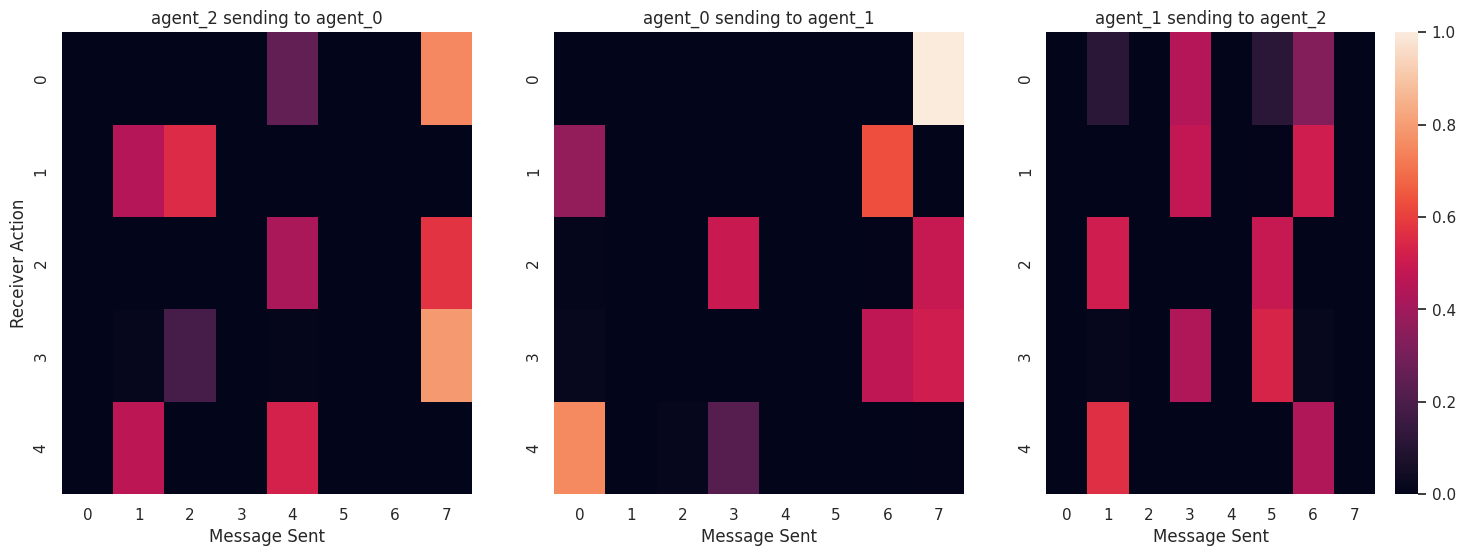

In [107]:
n_msgs = len(msg_cols)
n_actions = 5

agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(6 * len(agents), 6))
for i, agent in enumerate(agents):
    agent_df = df[df['sender'] == agent]
    recvs = agent_df['receiver'].unique()
    assert recvs.size == 1
    recv = recvs[0]

    agent_df = agent_df.groupby('receiver_action')['msg'].value_counts(normalize=True).unstack()
    agent_df = agent_df.fillna(0)
    counts = np.zeros((n_actions, n_msgs))
    for msg in agent_df.columns:
        for action in agent_df.index:
            counts[action, msg] = agent_df.loc[action, msg]

    sns.heatmap(counts, ax=axs[i], vmin=0, vmax=1, cbar=i == len(agents) - 1)
    axs[i].set_title(f'{agent} sending to {recv}')
    if i > 0:
        axs[i].set_ylabel('')
    else:
        axs[i].set_ylabel('Receiver Action')
    axs[i].set_xlabel('Message Sent')

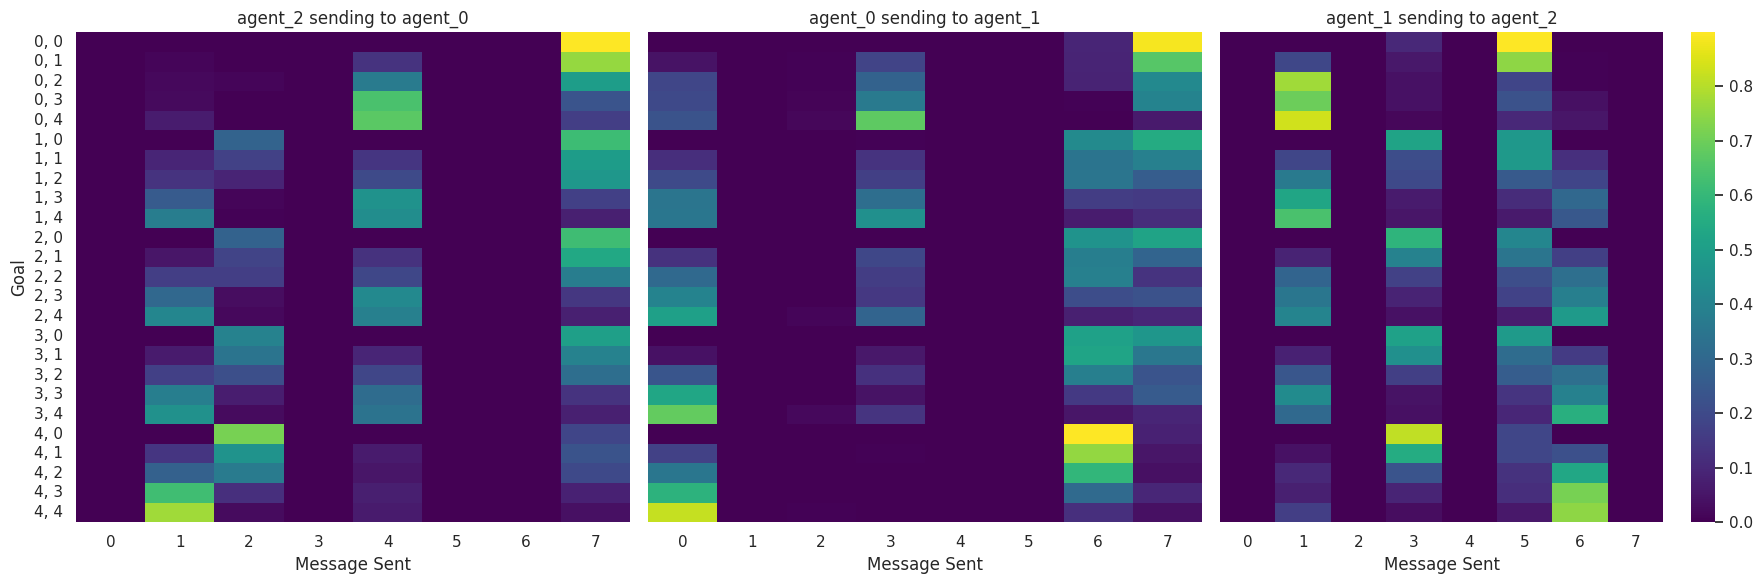

In [119]:
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(6 * len(agents), 6))
for i, agent in enumerate(agents):
    agent_df = df[df['sender'] == agent]
    recvs = agent_df['receiver'].unique()
    assert recvs.size == 1
    recv = recvs[0]
    agent_df = agent_df.groupby('goal_idx')['msg'].value_counts(normalize=True).unstack()
    counts_df = agent_df.fillna(0)
    counts = np.zeros((world_w * world_h, n_msgs))
    for msg in counts_df.columns:
        for goal_idx in counts_df.index:
            counts[goal_idx, msg] = counts_df.loc[goal_idx, msg]
    sns.heatmap(counts, cmap='viridis', ax=axs[i], cbar=i == len(agents) - 1)
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Goal')
        axs[i].set_yticklabels([
            f'{int(x)}, {int(y)}'
            for x in range(world_w)
            for y in range(world_h)
        ])
    axs[i].set_xlabel('Message Sent')
    axs[i].set_title(f'{agent} sending to {recv}')
plt.tight_layout()
plt.show()

In [122]:
agent_df = df[df['sender'] == agent]
agent_df

,receiver,sender,goal_x,goal_y,receiver_action,msg,msg_0,msg_1,msg_2,msg_3,msg_4,msg_5,msg_6,msg_7,goal_idx
2,agent_2,agent_1,4,0,2,1,0.000085,0.969933,0.000302,0.000104,0.000060,0.012466,0.016706,0.000344,4
5,agent_2,agent_1,4,0,4,1,0.000356,0.730631,0.001808,0.001975,0.000161,0.005656,0.258438,0.000976,4
8,agent_2,agent_1,4,0,4,1,0.001116,0.554032,0.004226,0.020686,0.000702,0.034035,0.382203,0.003002,4
11,agent_2,agent_1,0,4,3,3,0.000143,0.000113,0.000047,0.944207,0.000029,0.053083,0.002289,0.000089,20
14,agent_2,agent_1,0,4,3,3,0.000100,0.000068,0.000044,0.976171,0.000017,0.020110,0.003427,0.000062,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14483,agent_2,agent_1,3,2,1,6,0.000196,0.026376,0.000609,0.022610,0.000049,0.000770,0.948954,0.000437,13
14486,agent_2,agent_1,3,2,4,1,0.000290,0.580773,0.000843,0.011257,0.000103,0.014281,0.391527,0.000925,13
14489,agent_2,agent_1,3,2,4,1,0.000603,0.423582,0.001126,0.087438,0.000129,0.107935,0.377500,0.001686,13
14492,agent_2,agent_1,3,2,3,5,0.001605,0.122799,0.001582,0.361874,0.000429,0.423218,0.085338,0.003156,13


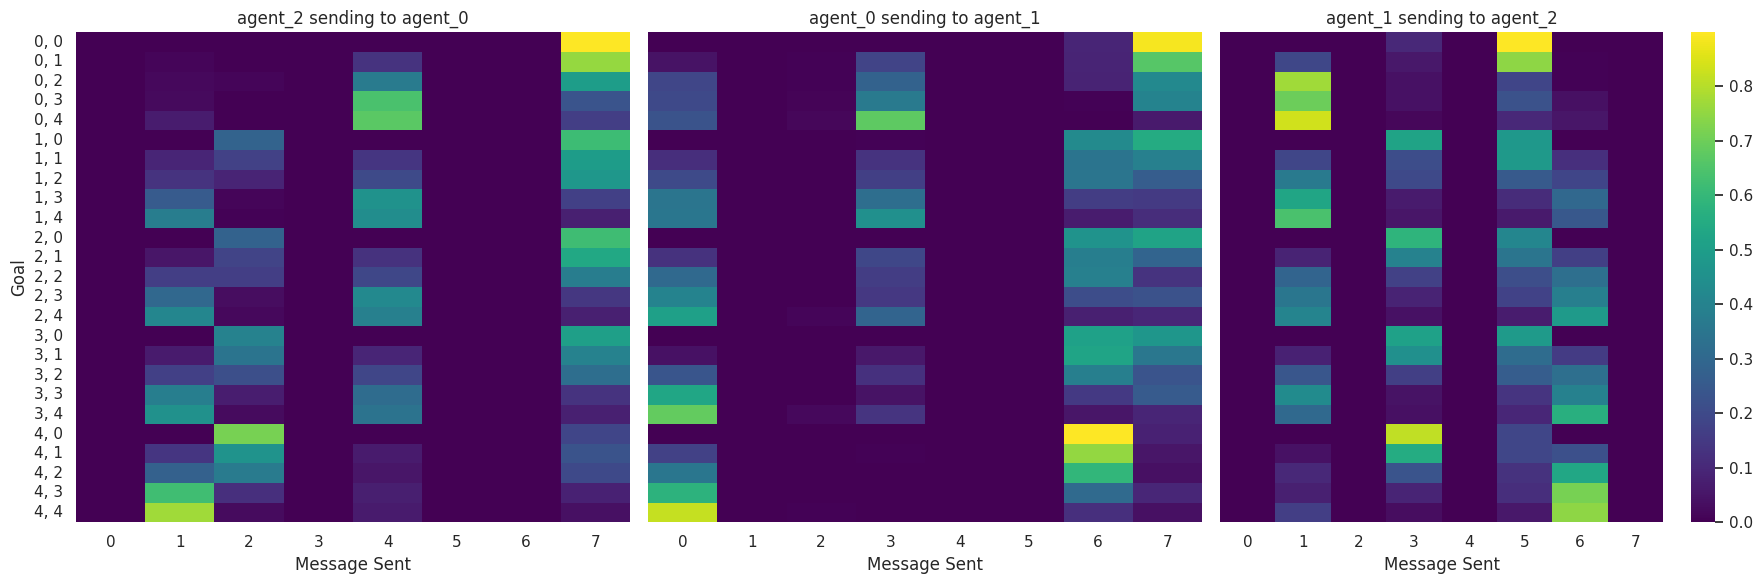

In [130]:
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(6 * len(agents), 6))
for i, agent in enumerate(agents):
    agent_df = df[df['sender'] == agent]
    recvs = agent_df['receiver'].unique()
    assert recvs.size == 1
    recv = recvs[0]
    agent_df = agent_df.groupby('goal_idx')['msg'].value_counts(normalize=True).unstack()
    counts_df = agent_df.fillna(0)
    counts = np.zeros((world_w * world_h, n_msgs))
    for msg in counts_df.columns:
        for goal_idx in counts_df.index:
            counts[goal_idx, msg] = counts_df.loc[goal_idx, msg]
    sns.heatmap(counts, cmap='viridis', ax=axs[i], cbar=i == len(agents) - 1)
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Goal')
        axs[i].set_yticklabels([
            f'{int(x)}, {int(y)}'
            for x in range(world_w)
            for y in range(world_h)
        ])
    axs[i].set_xlabel('Message Sent')
    axs[i].set_title(f'{agent} sending to {recv}')
plt.tight_layout()
plt.show()

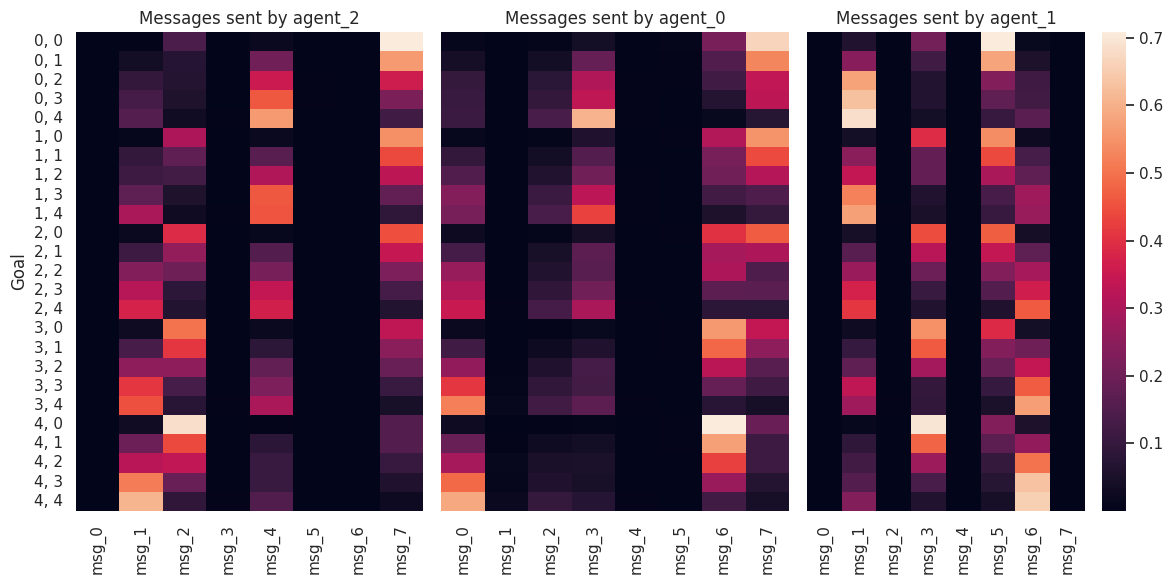

In [129]:
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(4 * len(agents), 6))
for i, agent in enumerate(agents):
    action_mean_msgs = df[df.sender == agent].groupby('goal_idx')[msg_cols].mean()
    action_mean_msgs = action_mean_msgs.reset_index().set_index('goal_idx')
    sns.heatmap(action_mean_msgs, ax=axs[i], cbar=i == len(agents) - 1)
    axs[i].set_title(f'Messages sent by {agent}')
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Goal')
        axs[i].set_yticklabels([
            f'{int(x)}, {int(y)}'
            for x in range(world_w)
            for y in range(world_h)
        ])
plt.tight_layout()
plt.show()

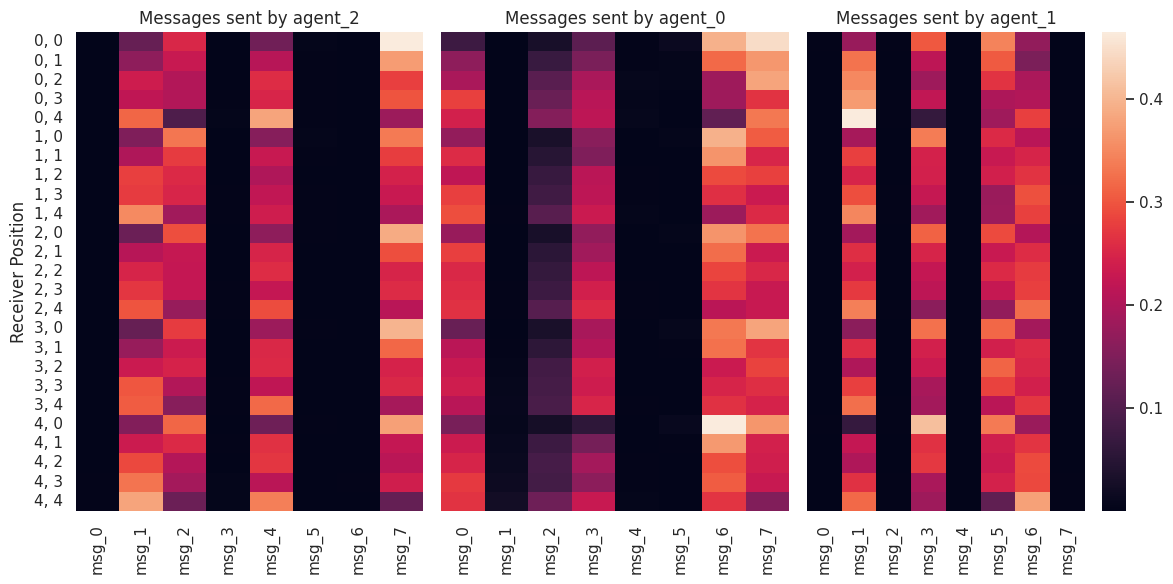

In [131]:
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(4 * len(agents), 6))
for i, agent in enumerate(agents):
    action_mean_msgs = df[df.sender == agent].groupby('pos_idx')[msg_cols].mean()
    action_mean_msgs = action_mean_msgs.reset_index().set_index('pos_idx')
    sns.heatmap(action_mean_msgs, ax=axs[i], cbar=i == len(agents) - 1)
    axs[i].set_title(f'Messages sent by {agent}')
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Receiver Position')
        axs[i].set_yticklabels([
            f'{int(x)}, {int(y)}'
            for x in range(world_w)
            for y in range(world_h)
        ])
plt.tight_layout()
plt.show()

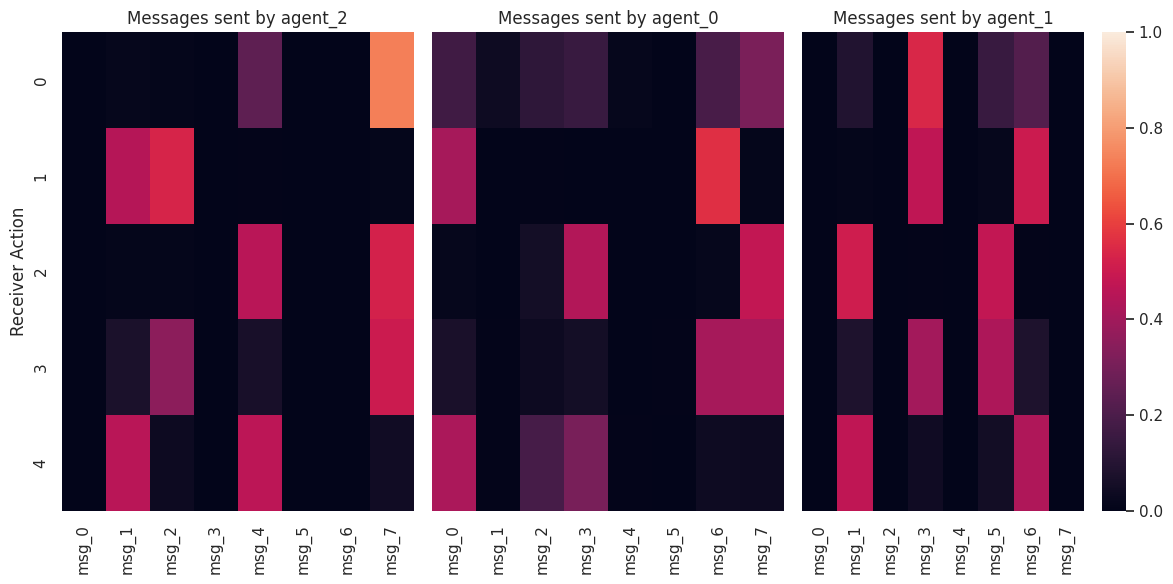

In [127]:
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(4 * len(agents), 6))
for i, agent in enumerate(agents):
    action_mean_msgs = df[df.sender == agent].groupby('receiver_action')[msg_cols].mean()
    action_mean_msgs = action_mean_msgs.reset_index().set_index('receiver_action')
    sns.heatmap(action_mean_msgs, ax=axs[i], cbar=i == len(agents) - 1, vmin=0, vmax=1)
    axs[i].set_title(f'Messages sent by {agent}')
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Receiver Action')

plt.tight_layout()
plt.show()

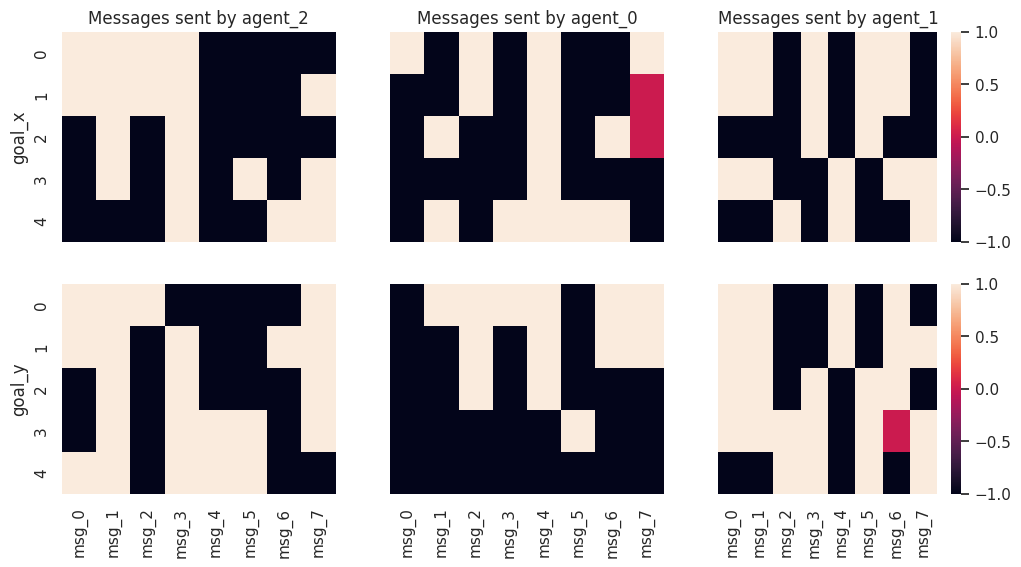

In [159]:
agents = df['sender'].unique()
_, axs_grid = plt.subplots(2, len(agents), figsize=(4 * len(agents), 6))
# msg_cols = [col for col in df.columns if col.startswith('msg')]
for i, agent in enumerate(agents):
    agent_df = df[df.sender == agent]
    
    goal_x_mean_msgs = agent_df.groupby('goal_x')[msg_cols].median()
    goal_x_mean_msgs = goal_x_mean_msgs.reset_index().set_index('goal_x')
    sns.heatmap(goal_x_mean_msgs, ax=axs_grid[0][i], cbar=i == len(agents) - 1, vmin=-1, vmax=1)

    goal_y_mean_msgs = agent_df.groupby('goal_y')[msg_cols].median()
    goal_y_mean_msgs = goal_y_mean_msgs.reset_index().set_index('goal_y')
    sns.heatmap(goal_y_mean_msgs, ax=axs_grid[1][i], cbar=i == len(agents) - 1, vmin=-1, vmax=1)

    axs_grid[0][i].set_title(f'Messages sent by {agent}')
    axs_grid[0][i].set_xticks([])
    if i > 0:
        axs_grid[0][i].set_ylabel('')
        axs_grid[0][i].set_yticks([])
        axs_grid[1][i].set_ylabel('')
        axs_grid[1][i].set_yticks([])

<AxesSubplot: >

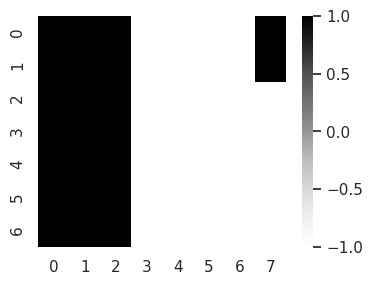

In [82]:
messages_01 = np.vstack([
    item['comms']['agent_0']['agent_1']
    for item in collect_comms_data_cb.data
    if item['episode_id'] == episodes[0]
])

plt.figure(figsize=(4, 3))
sns.heatmap(messages_01, vmin=-1, vmax=1, cmap='Greys')